In [100]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.transforms.functional as TF
from PIL import Image
import torch.nn.functional as F


In [308]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


def random_mask(img_size):
    """Generate a random square mask."""
    mask = torch.ones(img_size)
    mask_size = np.random.randint(img_size[1]//4, img_size[1]//2)  # Variable mask size
    x = np.random.randint(0, img_size[1] - mask_size)
    y = np.random.randint(0, img_size[2] - mask_size)
    mask[:, y:y+mask_size, x:x+mask_size] = 0
    return mask


class MaskedMNIST(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, _ = self.mnist_dataset[idx]
        mask = random_mask(img.size())
        masked_img = img * mask
        return masked_img, mask, img

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

masked_mnist_train = MaskedMNIST(mnist_data)

train_loader = DataLoader(masked_mnist_train, batch_size=16, shuffle=True)

In [306]:
def crop_to_mask(batch_images, batch_masks, crop_size):
    cropped_images = []
    for image, mask in zip(batch_images, batch_masks):
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)

        nonzero_indices = torch.nonzero(mask, as_tuple=False)
        if nonzero_indices.size(0) == 0:
            y1, y2, x1, x2 = 0, mask.size(1), 0, mask.size(2)
        else:
            y1, x1 = torch.min(nonzero_indices[:, 1:3], dim=0).values
            y2, x2 = torch.max(nonzero_indices[:, 1:3], dim=0).values

            center_y, center_x = (y1 + y2) // 2, (x1 + x2) // 2

            start_x = max(center_x - crop_size // 2, 0)
            end_x = min(start_x + crop_size, mask.size(2))
            start_y = max(center_y - crop_size // 2, 0)
            end_y = min(start_y + crop_size, mask.size(1))

            if (end_x - start_x) < crop_size:
                start_x = max(end_x - crop_size, 0)
            if (end_y - start_y) < crop_size:
                start_y = max(end_y - crop_size, 0)

        cropped_image = image[:, start_y:end_y, start_x:end_x]
        cropped_images.append(cropped_image)

    return torch.stack(cropped_images)

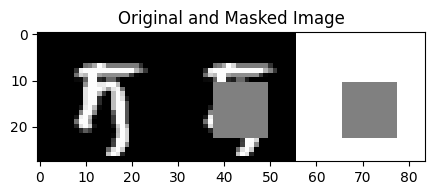

In [310]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray', interpolation='none')
    plt.title(title)
    plt.show()

dataiter = iter(train_loader)
masked_images, masks, original_images = next(dataiter)

imshow(torch.cat((original_images[0], masked_images[0], masks[0]), dim=2), "Original and Masked Image")

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # Accept two channels here
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # Output one channel
            nn.Tanh()
        )

    def forward(self, masked_images, masks):
        x = torch.cat((masked_images, masks), dim=1)  # Ensure masks and images are the same size
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class GlobalDiscriminator(nn.Module):
    def __init__(self):
        super(GlobalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # Changed from 3 to 1
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class LocalDiscriminator(nn.Module):
    def __init__(self):
        super(LocalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [9]:
def real_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_loss(D_out):
    return torch.mean(D_out**2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator()
global_discriminator = GlobalDiscriminator()
local_discriminator = LocalDiscriminator()
generator.to(device)
global_discriminator.to(device)
local_discriminator.to(device)
    
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_global_optimizer = optim.Adam(global_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_local_optimizer = optim.Adam(local_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [24]:
train_loader = train_loader
num_epochs = 25
lambda2 = 0.4
lambda1 = 0.6
crop_size = 10

for epoch in range(num_epochs):
    for masked_images, masks, real_images in train_loader:

        masked_images = masked_images.to(device)
        masks = masks.to(device)
        real_images = real_images.to(device)
        
        inpainted_images = generator(masked_images, masks)
        reconstruction_loss = torch.nn.functional.mse_loss(inpainted_images, real_images)
        
        D_global_real = global_discriminator(real_images)
        D_global_fake = global_discriminator(inpainted_images)

        cropped_real = crop_to_mask(real_images, masks, crop_size)
        cropped_fake = crop_to_mask(inpainted_images, masks, crop_size)
        D_local_real = local_discriminator(cropped_real)
        D_local_fake = local_discriminator(cropped_fake)

        global_real_loss = real_loss(D_global_real)
        global_fake_loss = fake_loss(D_global_fake)
        local_real_loss = real_loss(D_local_real)
        local_fake_loss = fake_loss(D_local_fake)
        
        d_global_loss = global_real_loss + global_fake_loss
        d_local_loss = local_real_loss + local_fake_loss

        d_total_loss = lambda2 * d_global_loss + lambda1 * d_local_loss

        d_global_optimizer.zero_grad()
        d_local_optimizer.zero_grad()
        d_total_loss.backward(retain_graph=True)
        d_global_optimizer.step()
        d_local_optimizer.step()

        inpainted_images = generator(masked_images, masks)
        D_global_fake = global_discriminator(inpainted_images)
        D_local_fake = local_discriminator(inpainted_images)

        g_loss = real_loss(D_global_fake) + real_loss(D_local_fake) + reconstruction_loss
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        

    print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {d_total_loss.item()} | G Loss: {g_loss.item()}")
    if (epoch+1) % 5 == 0:
        torch.save(generator.state_dict(), f"mnist_generator_epoch_{epoch+1}.pth")



Epoch 1/25 | D Loss: 0.48650920391082764 | G Loss: 0.67329341173172
Epoch 2/25 | D Loss: 0.49463146924972534 | G Loss: 0.6296811103820801
Epoch 3/25 | D Loss: 0.46581506729125977 | G Loss: 0.6872981786727905
Epoch 4/25 | D Loss: 0.39476364850997925 | G Loss: 0.7193692922592163
Epoch 5/25 | D Loss: 0.43255341053009033 | G Loss: 0.640983521938324
Epoch 6/25 | D Loss: 0.4605731666088104 | G Loss: 0.6709066033363342
Epoch 7/25 | D Loss: 0.387190043926239 | G Loss: 0.7262179255485535
Epoch 8/25 | D Loss: 0.3626786470413208 | G Loss: 0.6899030208587646
Epoch 9/25 | D Loss: 0.4918643832206726 | G Loss: 0.616681694984436
Epoch 10/25 | D Loss: 0.4874567985534668 | G Loss: 0.6173334121704102
Epoch 11/25 | D Loss: 0.40264764428138733 | G Loss: 0.6110340356826782
Epoch 12/25 | D Loss: 0.39666664600372314 | G Loss: 0.6359025835990906
Epoch 13/25 | D Loss: 0.5461217761039734 | G Loss: 0.6986947655677795
Epoch 14/25 | D Loss: 0.424330472946167 | G Loss: 0.6320509314537048
Epoch 15/25 | D Loss: 0.2993

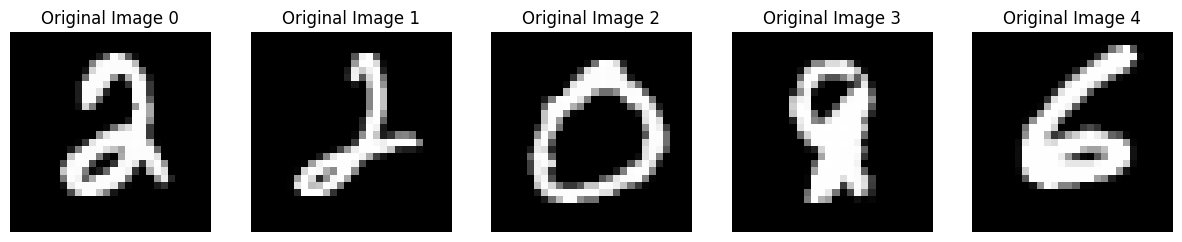

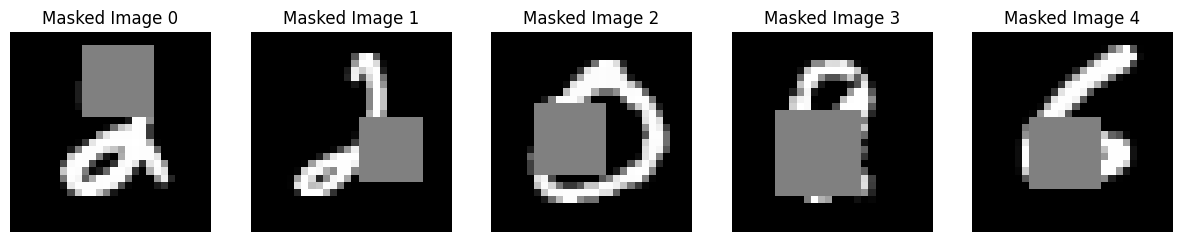

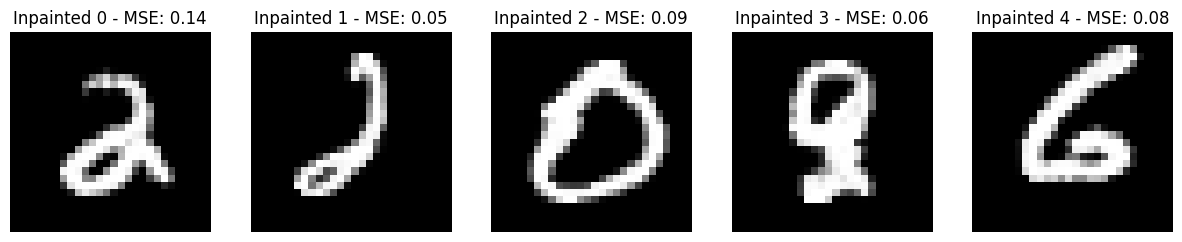

In [314]:
def show_images(images, titles, cols=5):
    assert len(images) == len(titles)
    num_images = len(images)
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        img = images[idx].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(titles[idx])
        ax.axis('off')
    plt.show()

dataiter = iter(train_loader)
masked_images, masks, original_images = next(dataiter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_images = masked_images.to(device)
masks = masks.to(device)
generator.to(device)

with torch.no_grad():
    inpainted_images = generator(masked_images, masks)

original_images = original_images.cpu()
masked_images = masked_images.cpu()
inpainted_images = inpainted_images.cpu()

num_display = 5
mse_scores = [F.mse_loss(inpainted_images[i], original_images[i], reduction='mean').item() for i in range(num_display)]

show_images([original_images[i] for i in range(num_display)], ["Original Image {}".format(i) for i in range(num_display)])
show_images([masked_images[i] for i in range(num_display)], ["Masked Image {}".format(i) for i in range(num_display)])
show_images([inpainted_images[i] for i in range(num_display)], ["Inpainted {} - MSE: {:.2f}".format(i, mse_scores[i]) for i in range(num_display)])


In [ ]:
# photos

In [ ]:
# bigger model needed

In [292]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),                        
    transforms.Normalize((0.5,), (0.5,))        
])

def random_mask(img_size):
    """Generate a random square mask."""
    mask = torch.ones(img_size)
    mask_size = np.random.randint(img_size[1]//4, img_size[1]//2)
    x = np.random.randint(0, img_size[1] - mask_size)
    y = np.random.randint(0, img_size[2] - mask_size)
    mask[:, y:y+mask_size, x:x+mask_size] = 0
    return mask

class MaskedCIFAR10(Dataset):
    def __init__(self, cifar_dataset):
        self.cifar_dataset = cifar_dataset

    def __len__(self):
        return len(self.cifar_dataset)

    def __getitem__(self, idx):
        img, _ = self.cifar_dataset[idx]
        mask = random_mask(img.size())
        masked_img = img * mask
        return masked_img, mask, img 


cifar10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

masked_cifar10_train = MaskedCIFAR10(cifar10_data)

train_loader_cifar10 = DataLoader(masked_cifar10_train, batch_size=16, shuffle=True)

Files already downloaded and verified


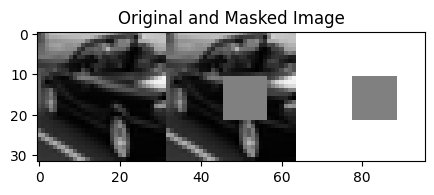

In [38]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray', interpolation='none')
    plt.title(title)
    plt.show()

dataiter = iter(train_loader_cifar10)
masked_images, masks, original_images = next(dataiter)

imshow(torch.cat((original_images[0], masked_images[0], masks[0]), dim=2), "Original and Masked Image")

In [40]:
class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Additional layer
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, masked_images, masks):
        x = torch.cat((masked_images, masks), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x



class GlobalDiscriminator2(nn.Module):
    def __init__(self):
        super(GlobalDiscriminator2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Additional layer
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class LocalDiscriminator2(nn.Module):
    def __init__(self):
        super(LocalDiscriminator2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Additional layer
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [41]:
def real_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_loss(D_out):
    return torch.mean(D_out**2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator_cifar10 = Generator2()
global_discriminator_cifar10 = GlobalDiscriminator2()
local_discriminator_cifar10 = LocalDiscriminator2()

device = torch.device("cuda")
generator_cifar10.to(device)
global_discriminator_cifar10.to(device)
local_discriminator_cifar10.to(device)
    
g_optimizer = optim.Adam(generator_cifar10.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_global_optimizer = optim.Adam(global_discriminator_cifar10.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_local_optimizer = optim.Adam(local_discriminator_cifar10.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [42]:
train_loader = train_loader_cifar10
num_epochs = 25
lambda2 = 0.4
lambda1 = 0.6
crop_size = 10

for epoch in range(num_epochs):
    for masked_images, masks, real_images in train_loader:

        masked_images = masked_images.to(device)
        masks = masks.to(device)
        real_images = real_images.to(device)
        
        
        inpainted_images = generator_cifar10(masked_images, masks)
        reconstruction_loss = torch.nn.functional.mse_loss(inpainted_images, real_images)
        
        D_global_real = global_discriminator_cifar10(real_images)
        D_global_fake = global_discriminator_cifar10(inpainted_images)

        cropped_real = crop_to_mask(real_images, masks, crop_size)
        cropped_fake = crop_to_mask(inpainted_images, masks, crop_size)
        D_local_real = local_discriminator_cifar10(cropped_real)
        D_local_fake = local_discriminator_cifar10(cropped_fake)

        global_real_loss = real_loss(D_global_real)
        global_fake_loss = fake_loss(D_global_fake)
        local_real_loss = real_loss(D_local_real)
        local_fake_loss = fake_loss(D_local_fake)
        
        d_global_loss = global_real_loss + global_fake_loss
        d_local_loss = local_real_loss + local_fake_loss

        d_total_loss = lambda2 * d_global_loss + lambda1 * d_local_loss

        d_global_optimizer.zero_grad()
        d_local_optimizer.zero_grad()
        d_total_loss.backward(retain_graph=True)
        d_global_optimizer.step()
        d_local_optimizer.step()

        inpainted_images = generator_cifar10(masked_images, masks)
        D_global_fake = global_discriminator_cifar10(inpainted_images)
        D_local_fake = local_discriminator_cifar10(inpainted_images)

        g_loss = real_loss(D_global_fake) + real_loss(D_local_fake) + reconstruction_loss
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

   
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {d_total_loss.item()} | G Loss: {g_loss.item()}")
        torch.save(generator_cifar10.state_dict(), f"cifar10_generator_epoch_{epoch+1}.pth")
    

Epoch 5/25 | D Loss: 0.3326842486858368 | G Loss: 1.4214982986450195
Epoch 10/25 | D Loss: 0.18601110577583313 | G Loss: 1.6553202867507935
Epoch 15/25 | D Loss: 0.12457992881536484 | G Loss: 1.874314308166504
Epoch 20/25 | D Loss: 0.10776820778846741 | G Loss: 1.5905237197875977
Epoch 25/25 | D Loss: 0.19919341802597046 | G Loss: 1.6843945980072021


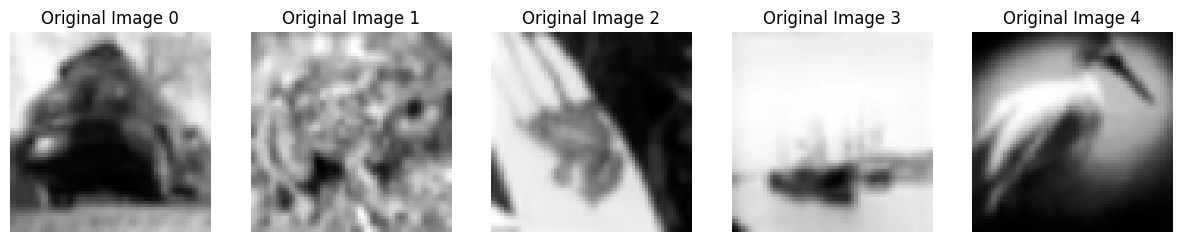

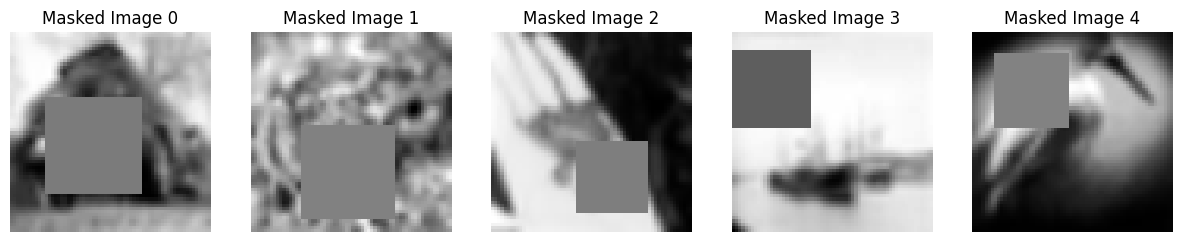

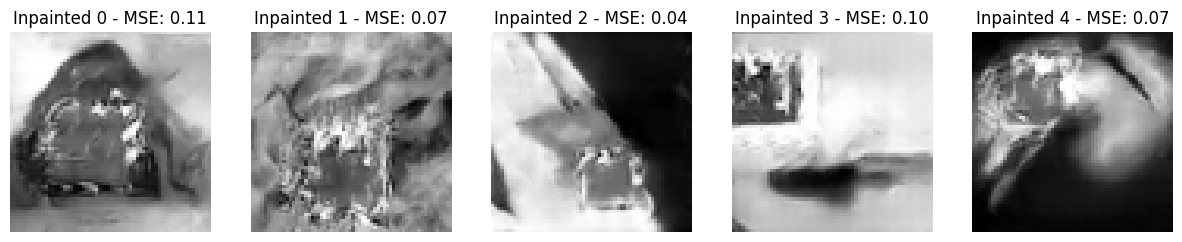

In [295]:
def show_images(images, titles, cols=5):
    assert len(images) == len(titles)  # Ensure each image has a title
    num_images = len(images)
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        img = images[idx].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(titles[idx])
        ax.axis('off')
    plt.show()

dataiter = iter(train_loader)
masked_images, masks, original_images = next(dataiter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_images = masked_images.to(device)
masks = masks.to(device)
generator.to(device)

with torch.no_grad():
    inpainted_images = generator_cifar10(masked_images, masks)

original_images = original_images.cpu()
masked_images = masked_images.cpu()
inpainted_images = inpainted_images.cpu()

num_display = 5  # Number of images to display
mse_scores = [F.mse_loss(inpainted_images[i], original_images[i], reduction='mean').item() for i in range(num_display)]

show_images([original_images[i] for i in range(num_display)], ["Original Image {}".format(i) for i in range(num_display)])
show_images([masked_images[i] for i in range(num_display)], ["Masked Image {}".format(i) for i in range(num_display)])
show_images([inpainted_images[i] for i in range(num_display)], ["Inpainted {} - MSE: {:.2f}".format(i, mse_scores[i]) for i in range(num_display)])

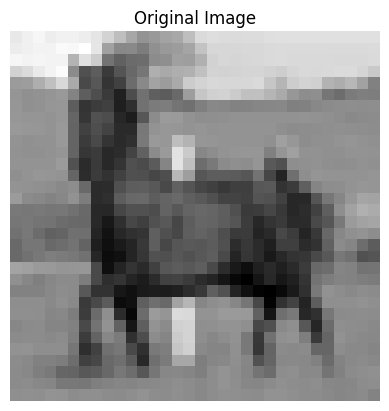

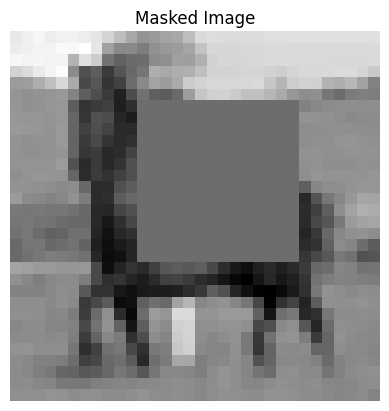

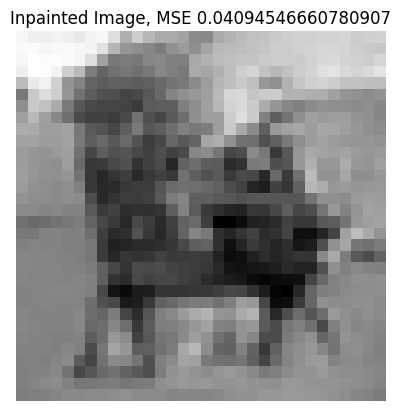

In [296]:
generator_cifar10.load_state_dict(torch.load("cifar10_generator_epoch_25.pth"))


data_loader = train_loader_cifar10
masked_images, masks, original_images = next(iter(data_loader))

def imshow(img, title):
    npimg = img.numpy().squeeze()  # remove batch dimension and channel
    plt.imshow(npimg, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

imshow(original_images[9], "Original Image")
imshow(masked_images[9], "Masked Image")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_images = masked_images.to(device)
masks = masks.to(device)
generator.to(device)

with torch.no_grad():  
    inpainted_images = generator_cifar10(masked_images, masks)
if inpainted_images.is_cuda:
    inpainted_images = inpainted_images.cpu()
    
mse_score = F.mse_loss(inpainted_images[9], original_images[9], reduction='mean').item()

imshow(inpainted_images[9], f"Inpainted Image, MSE {mse_score}")

original_np = original_images[4].numpy().squeeze()
inpainted_np = inpainted_images[4].numpy().squeeze()

In [ ]:
# bigger model, maybe better results

In [297]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),                      
    transforms.Normalize((0.5,), (0.5,))         
])

def random_mask(img_size):
    """Generate a random square mask."""
    mask = torch.ones(img_size)
    mask_size = np.random.randint(img_size[1]//4, img_size[1]//2)  # Variable mask size
    x = np.random.randint(0, img_size[1] - mask_size)
    y = np.random.randint(0, img_size[2] - mask_size)
    mask[:, y:y+mask_size, x:x+mask_size] = 0
    return mask

class MaskedCIFAR10(Dataset):
    def __init__(self, cifar_dataset):
        self.cifar_dataset = cifar_dataset

    def __len__(self):
        return len(self.cifar_dataset)

    def __getitem__(self, idx):
        img, _ = self.cifar_dataset[idx]
        mask = random_mask(img.size())
        masked_img = img * mask
        return masked_img, mask, img  # Return the masked image, the mask, and the original image


cifar10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

masked_cifar10_train = MaskedCIFAR10(cifar10_data)

train_loader_cifar10 = DataLoader(masked_cifar10_train, batch_size=16, shuffle=True)


Files already downloaded and verified


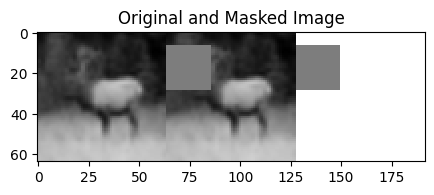

In [170]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray', interpolation='none')
    plt.title(title)
    plt.show()

dataiter = iter(train_loader_cifar10)
masked_images, masks, original_images = next(dataiter)

imshow(torch.cat((original_images[0], masked_images[0], masks[0]), dim=2), "Original and Masked Image")

In [304]:
class Generator3(nn.Module):
    def __init__(self):
        super(Generator3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )

    def forward(self, masked_images, masks):
        x = torch.cat((masked_images, masks), dim=1)  # Concatenation along channel dimension
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class GlobalDiscriminator3(nn.Module):
    def __init__(self):
        super(GlobalDiscriminator3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # 8x8 -> 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # 4x4 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class LocalDiscriminator3(nn.Module):
    def __init__(self):
        super(LocalDiscriminator3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [180]:
def real_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_loss(D_out):
    return torch.mean(D_out**2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator_cifar10_resized = Generator3()
global_discriminator_cifar10_resized = GlobalDiscriminator3()
local_discriminator_cifar10_resized = LocalDiscriminator3()

device = torch.device("cuda")
generator_cifar10_resized.to(device)
global_discriminator_cifar10_resized.to(device)
local_discriminator_cifar10_resized.to(device)
    
g_optimizer = optim.Adam(generator_cifar10_resized.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_global_optimizer = optim.Adam(global_discriminator_cifar10_resized.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_local_optimizer = optim.Adam(local_discriminator_cifar10_resized.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [181]:
train_loader = train_loader_cifar10
num_epochs = 25
lambda2 = 0.4
lambda1 = 0.6
crop_size = 20

for epoch in range(num_epochs):
    for masked_images, masks, real_images in train_loader:
        masked_images = masked_images.to(device)
        masks = masks.to(device)
        real_images = real_images.to(device)
   
        d_global_optimizer.zero_grad()
        d_local_optimizer.zero_grad()
        g_optimizer.zero_grad()

        inpainted_images = generator_cifar10_resized(masked_images, masks)
        reconstruction_loss = torch.nn.functional.mse_loss(inpainted_images, real_images)

        D_global_real = global_discriminator_cifar10_resized(real_images)
        D_global_fake = global_discriminator_cifar10_resized(inpainted_images)

        cropped_real = crop_to_mask(real_images, masks, crop_size)
        cropped_fake = crop_to_mask(inpainted_images, masks, crop_size)
        D_local_real = local_discriminator_cifar10_resized(cropped_real)
        D_local_fake = local_discriminator_cifar10_resized(cropped_fake)

        global_real_loss = real_loss(D_global_real)
        global_fake_loss = fake_loss(D_global_fake)
        local_real_loss = real_loss(D_local_real)
        local_fake_loss = fake_loss(D_local_fake)

        d_global_loss = global_real_loss + global_fake_loss
        d_local_loss = local_real_loss + local_fake_loss
        d_total_loss = lambda2 * d_global_loss + lambda1 * d_local_loss

        d_total_loss.backward(retain_graph=True)
        d_global_optimizer.step()
        d_local_optimizer.step()

        D_global_fake = global_discriminator_cifar10_resized(inpainted_images)
        D_local_fake = local_discriminator_cifar10_resized(inpainted_images)

        g_loss = real_loss(D_global_fake) + real_loss(D_local_fake) + reconstruction_loss
        g_loss.backward()
        g_optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {d_total_loss.item()} | G Loss: {g_loss.item()}")

    if (epoch+1) % 5 == 0:
        torch.save(generator_cifar10_resized.state_dict(), f"cifar10_resized_generator_epoch_{epoch+1}.pth")


Epoch 1/25 | D Loss: 5.72682693018578e-05 | G Loss: 1.0236250162124634
Epoch 2/25 | D Loss: 3.142136847600341e-05 | G Loss: 1.0150728225708008
Epoch 3/25 | D Loss: 1.303192948398646e-05 | G Loss: 1.0122740268707275
Epoch 4/25 | D Loss: 0.4000031054019928 | G Loss: 1.017426609992981
Epoch 5/25 | D Loss: 5.6394383136648685e-06 | G Loss: 1.0139285326004028
Epoch 6/25 | D Loss: 5.015580427425448e-06 | G Loss: 1.0095218420028687
Epoch 7/25 | D Loss: 3.6431320040719584e-05 | G Loss: 1.0115437507629395
Epoch 8/25 | D Loss: 2.8975446184631437e-06 | G Loss: 1.0085477828979492
Epoch 9/25 | D Loss: 1.3932673255112604e-06 | G Loss: 1.0095188617706299
Epoch 10/25 | D Loss: 7.655601734768425e-07 | G Loss: 1.0107568502426147
Epoch 11/25 | D Loss: 4.433805997905438e-07 | G Loss: 1.010905146598816
Epoch 12/25 | D Loss: 3.743843990378082e-05 | G Loss: 1.0113656520843506
Epoch 13/25 | D Loss: 1.8896586198025034e-06 | G Loss: 1.010694146156311
Epoch 14/25 | D Loss: 4.753498785703414e-07 | G Loss: 1.009596

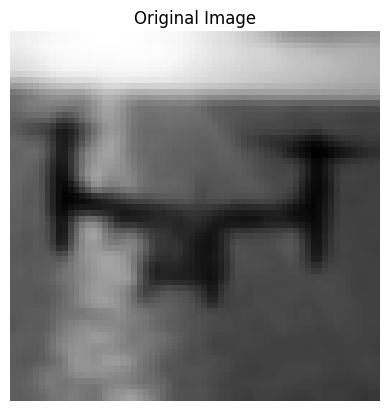

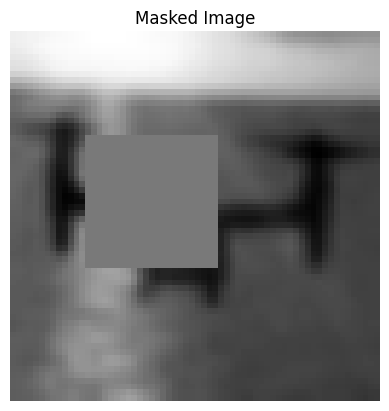

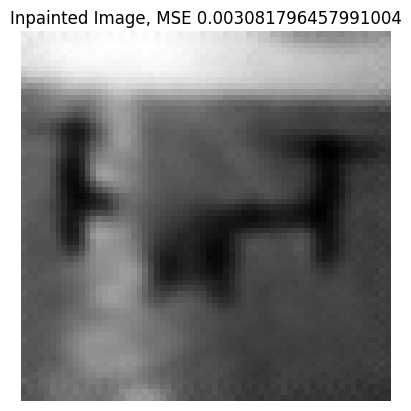

In [289]:
data_loader = train_loader
masked_images, masks, original_images = next(iter(data_loader))

def imshow(img, title):
    npimg = img.numpy().squeeze()  
    plt.imshow(npimg, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

imshow(original_images[9], "Original Image")
imshow(masked_images[9], "Masked Image")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_images = masked_images.to(device)
masks = masks.to(device)
generator.to(device)

with torch.no_grad(): 
    inpainted_images = generator_cifar10_resized(masked_images, masks) 

if inpainted_images.is_cuda:
    inpainted_images = inpainted_images.cpu()


mse_score = F.mse_loss(inpainted_images[9], original_images[9], reduction='mean').item()

imshow(inpainted_images[9], f"Inpainted Image, MSE {mse_score}")

original_np = original_images[4].numpy().squeeze()
inpainted_np = inpainted_images[4].numpy().squeeze()



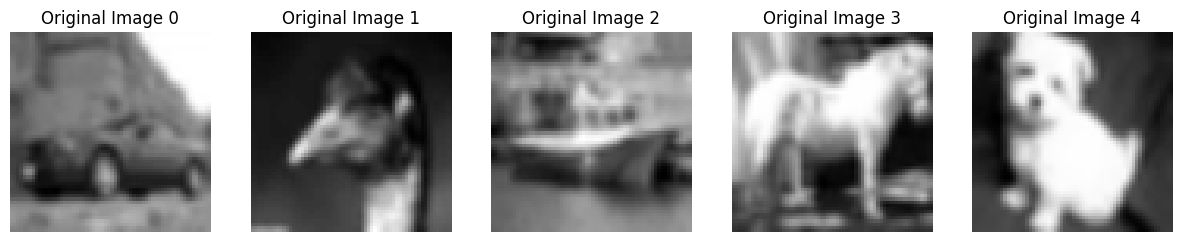

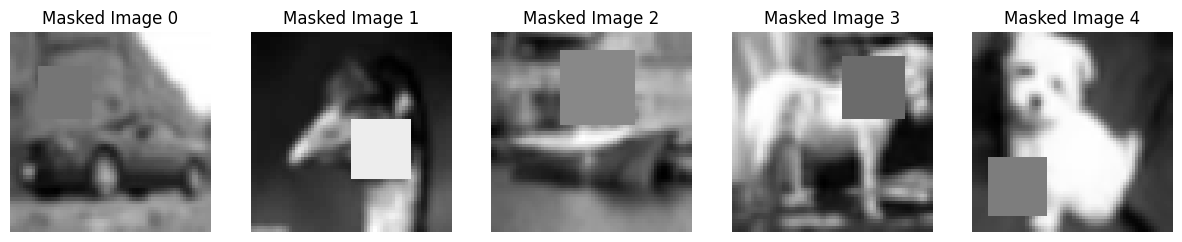

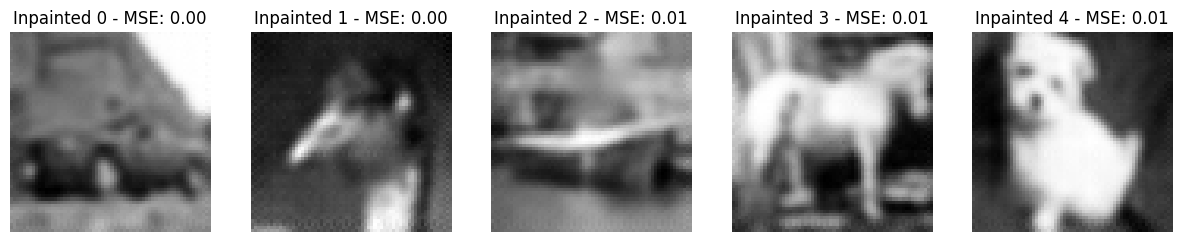

In [303]:
def show_images(images, titles, cols=5):
    assert len(images) == len(titles)
    num_images = len(images)
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        img = images[idx].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(titles[idx])
        ax.axis('off')
    plt.show()

dataiter = iter(train_loader)
masked_images, masks, original_images = next(dataiter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_images = masked_images.to(device)
masks = masks.to(device)
generator.to(device)

with torch.no_grad():
    inpainted_images = generator_cifar10_resized(masked_images, masks)

original_images = original_images.cpu()
masked_images = masked_images.cpu()
inpainted_images = inpainted_images.cpu()

num_display = 5
mse_scores = [F.mse_loss(inpainted_images[i], original_images[i], reduction='mean').item() for i in range(num_display)]

show_images([original_images[i] for i in range(num_display)], ["Original Image {}".format(i) for i in range(num_display)])
show_images([masked_images[i] for i in range(num_display)], ["Masked Image {}".format(i) for i in range(num_display)])
show_images([inpainted_images[i] for i in range(num_display)], ["Inpainted {} - MSE: {:.2f}".format(i, mse_scores[i]) for i in range(num_display)])